In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler

In [3]:
backend = AerSimulator(method = 'statevector')

In [4]:
backend.set_options(
    max_parallel_threads = 0,
    max_parallel_experiments = 0,
    max_parallel_shots = 1,
    statevector_parallel_threshold = 10
)

In [5]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, OneHotEncoder

features, labels = load_wine(return_X_y=True)

In [6]:
dim = features.shape[1]
num_classes = len(set(labels))

In [7]:
print(f"dimension: {dim}, classes: {num_classes}")

dimension: 13, classes: 3


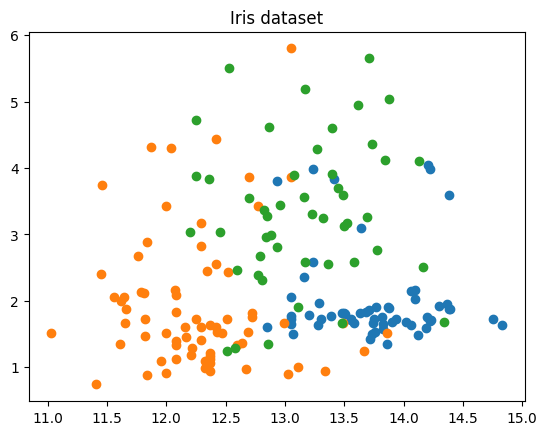

In [8]:
for k in range(0, num_classes):
    plt.scatter(features[labels == k, 0][:features.shape[0]], features[labels == k, 1][:features.shape[0]])
    plt.title("Iris dataset")
plt.show()

In [9]:
features = MinMaxScaler().fit_transform(features)

In [10]:
labels = np.array(labels)
ohe_transformer = OneHotEncoder()
labels = ohe_transformer.fit_transform(labels.reshape(-1,1)).toarray()

In [11]:
algorithm_globals.random_seed = 123
train_size = 0.8
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [12]:
train_features_size = train_features.shape[0]
test_features_size = test_features.shape[0]

In [13]:
print(f"train size: {train_features_size}, test size: {test_features_size}")

train size: 142, test size: 36


In [14]:
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [15]:
optimizer = SPSA(maxiter=200)
feature_map = ZZFeatureMap(feature_dimension=dim, reps=1)
var_form = TwoLocal(dim, ['ry', 'rz'], 'cz', reps=4, entanglement='full')
sampler = Sampler(backend=backend)
vqc = VQC(optimizer = optimizer, feature_map = feature_map, ansatz=var_form, loss="cross_entropy", callback=callback_graph, sampler=sampler)

/tmp/ipykernel_3875/400918669.py:4: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(backend=backend)


In [16]:
#vqc.circuit.draw(output='mpl')

In [17]:
#vqc.feature_map.decompose().draw(output='mpl')

In [18]:
#vqc.ansatz.decompose().draw(output='mpl')

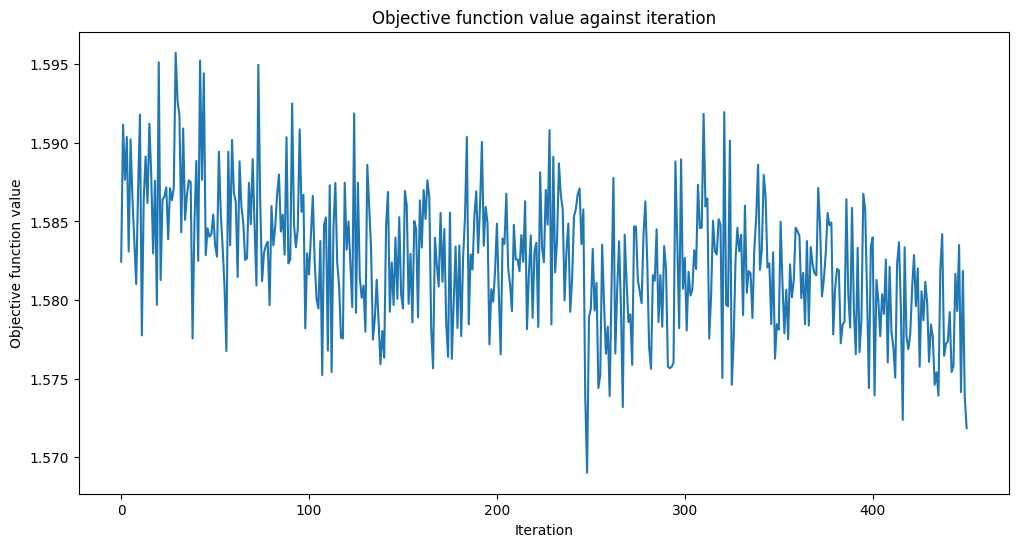

CPU times: user 5h 11min 24s, sys: 1min 16s, total: 5h 12min 41s
Wall time: 30min 39s


In [19]:
%%time
vqc.fit(train_features, train_labels)

In [20]:
vqc.score(train_features, train_labels)

0.49295774647887325

In [21]:
vqc.score(test_features, test_labels)

0.25